In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")
from dataloader.svdd_dataloader import CollisionLoader_new
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import librosa
from load_data import load_data
from deepod.metrics import ts_metrics
from deepod.metrics import point_adjustment 
%matplotlib inline

In [2]:
train_imu,train_audio,train_spec,val_imu,val_audio,val_spec,val_imu_normal,val_audio_normal,val_spec_normal,total_list = load_data()

train_combine = np.concatenate([np.mean(train_audio,axis=-1),train_imu],axis=1)

test_audio_all = np.concatenate([val_audio_normal,val_audio],axis=0)
test_imu_all   = np.concatenate([val_imu_normal,val_imu],axis=0)
test_combine = np.concatenate([np.mean(test_audio_all,axis=-1),test_imu_all],axis=1)

labels_all = np.concatenate([np.zeros(val_audio_normal.shape[0]),np.ones(val_audio.shape[0])])

In [3]:
clf_audio = OneClassSVM().fit(np.mean(train_audio,axis=-1))
clf_imu = OneClassSVM().fit(train_imu)
clf_all = OneClassSVM().fit(train_combine)

In [4]:
scores_audio       = -clf_audio.decision_function(np.mean(test_audio_all,axis=-1))
scores_imu         = -clf_imu.decision_function(test_imu_all)
scores_all         = -clf_all.decision_function(test_combine)
eval_metrics_audio = ts_metrics(labels_all, scores_audio)
eval_metrics_imu   = ts_metrics(labels_all, scores_imu+scores_audio)
result_audio       = eval_metrics_audio
result_imu = eval_metrics_imu
eval_metrics_all = ts_metrics(labels_all, scores_all)
result_all = eval_metrics_all

print(result_audio[:-2])
print(result_imu[:-2])
print(result_all[:-2])

# np.save("ovsnm_p",result_imu[-2])
# np.save("ovsnm_r",result_imu[-1])

(0.9500639619883041, 0.9258310004473428, 0.8823479415885708, 0.8746898263027295, 0.8901515151515151)
(0.8769853136629451, 0.830357696362303, 0.8113157548189938, 0.8082706766917294, 0.8143939393939394)
(0.5217886097820308, 0.44369147821757526, 0.565710228763788, 0.3944223107569721, 1.0)


In [11]:
from sklearn import metrics
precision, recall, thresholds= metrics.precision_recall_curve(labels_all, (scores_audio))
epsilon = 1e-10

f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(best_threshold)
indoor_group = []
outdoor_group = []
mach_group = []
coli_group = []
for idx, filepath in enumerate(total_list):
    parts = filepath.split('/')
    sequence = parts[-2]  # e.g., 'iseq2', 'iseq5', 'seq16'
    if sequence=='seq16':
        file_number = int(parts[-1].split('.')[0])  # Extract file number from filename (e.g., '0' from '0.npy')

    # Check if the file belongs to the indoor group (iseq2, iseq5, or seq16 with 0-104.npy)
    if sequence in ['iseq2', 'iseq5'] or (sequence == 'seq16' and  file_number >= 104):
        indoor_group.append(idx)  # Add the index of the file
    elif sequence in ['seq15', 'seq10'] or (sequence == 'seq16' and  file_number < 104):
        outdoor_group.append(idx)  # Add the index of the file
    elif sequence in ['bl', 'br','fl','fr']:
        mach_group.append(idx)  # Add the index of the file
    else:
        coli_group.append(idx)  # Add the index of the file

indoor_losses = [scores_audio[idx] for idx in indoor_group]
outdoor_losses = [scores_audio[idx] for idx in outdoor_group]
mach_losses = [scores_audio[idx] for idx in mach_group]
coli_losses = [scores_audio[idx] for idx in coli_group]

64.09575658933971


In [12]:
# Given threshold
threshold = best_threshold
# Example threshold, replace with actual value

# True labels for indoor and outdoor groups
true_labels_indoor = [0] * len(indoor_losses)  # All indoor samples are normal
true_labels_outdoor = [0] * len(outdoor_losses)  # All outdoor samples are anomalies

# Combine losses and true labels
all_losses = indoor_losses + outdoor_losses
all_true_labels = true_labels_indoor + true_labels_outdoor

# Calculate predicted labels based on the threshold
predicted_labels = [1 if score > threshold else 0 for score in all_losses]

# Calculate accuracy
correct_predictions = sum(pred == true for pred, true in zip(predicted_labels, all_true_labels))
total_samples = len(all_true_labels)
accuracy = correct_predictions / total_samples if total_samples > 0 else 0

# Output accuracy for both groups
print("Overall Accuracy:")
print(f"  Accuracy: {accuracy:.4f}")

# Optional: Calculate accuracy separately for indoor and outdoor groups
accuracy_indoor = sum(predicted_labels[i] == true_labels_indoor[i] for i in range(len(indoor_losses))) / len(indoor_losses) if len(indoor_losses) > 0 else 0
accuracy_outdoor = sum(predicted_labels[len(indoor_losses) + i] == true_labels_outdoor[i] for i in range(len(outdoor_losses))) / len(outdoor_losses) if len(outdoor_losses) > 0 else 0

print("\nIndoor Group Accuracy:")
print(f"  Accuracy: {accuracy_indoor:.4f}")

print("\nOutdoor Group Accuracy:")
print(f"  Accuracy: {accuracy_outdoor:.4f}")


Overall Accuracy:
  Accuracy: 0.9169

Indoor Group Accuracy:
  Accuracy: 0.8941

Outdoor Group Accuracy:
  Accuracy: 0.9425


In [13]:
true_labels_mach = [1] * len(mach_losses)  # All indoor samples are normal
true_labels_coli = [1] * len(coli_losses)  # All outdoor samples are anomalies

# Combine losses and true labels
all_losses = mach_losses + coli_losses
all_true_labels = true_labels_mach + true_labels_coli

# Calculate predicted labels based on the threshold
predicted_labels = [1 if score > threshold else 0 for score in all_losses]

# Calculate accuracy
correct_predictions = sum(pred == true for pred, true in zip(predicted_labels, all_true_labels))
total_samples = len(all_true_labels)
accuracy = correct_predictions / total_samples if total_samples > 0 else 0

# Output accuracy for both groups
print("Overall Accuracy:")
print(f"  Accuracy: {accuracy:.4f}")

# Optional: Calculate accuracy separately for indoor and outdoor groups
accuracy_mach = sum(predicted_labels[i] == true_labels_mach[i] for i in range(len(mach_losses))) / len(mach_losses) if len(mach_losses) > 0 else 0
accuracy_coli = sum(predicted_labels[len(mach_losses) + i] == true_labels_coli[i] for i in range(len(coli_losses))) / len(coli_losses) if len(outdoor_losses) > 0 else 0

print("\nmach Group Accuracy:")
print(f"  Accuracy: {accuracy_mach:.4f}")

print("\ncoli Group Accuracy:")
print(f"  Accuracy: {accuracy_coli:.4f}")

Overall Accuracy:
  Accuracy: 0.8889

mach Group Accuracy:
  Accuracy: 0.9591

coli Group Accuracy:
  Accuracy: 0.7599


In [5]:
# x = np.load('ovsnm_p.npy')
# y = np.load('ovsnm_r.npy')
# import matplotlib.pyplot as plt
# plt.plot(x,y)

In [5]:
# eval_metrics_audio = ts_metrics(labels_all, scores_audio)
# eval_metrics_imu = ts_metrics(labels_all, scores_imu)
# result_audio = eval_metrics_audio
# result_imu = eval_metrics_imu
# eval_metrics_all = ts_metrics(labels_all, scores_all)
# result_all = eval_metrics_all

# print(result_audio)
# print(result_imu)
# print(result_all)

(0.9362384891315986, 0.9129787928484991, 0.8613267096072894, 0.834319526627219, 0.8901515151515151)
(0.8558531427347682, 0.8674069633952347, 0.7745701642544582, 0.9340463458110517, 0.6616161616161617)
(0.919435075132955, 0.914951234414229, 0.8048731416967039, 0.9318936877076412, 0.7083333333333334)


Text(0.5, 1.0, 'Reconstruction Loss Distribution')

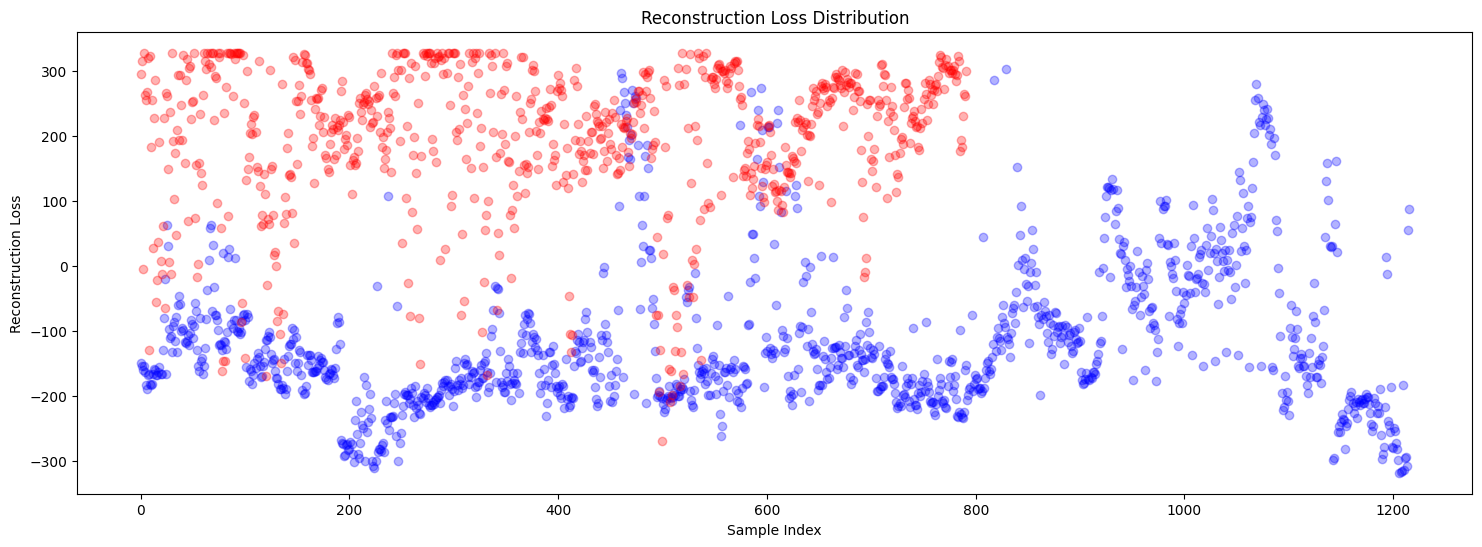

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))

plt.scatter(range(len(val_audio_normal)), scores_audio[:len(val_audio_normal)], color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(val_audio)), scores_audio[len(val_audio_normal):], color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
# plt.ylim(-0.2,2)

In [19]:
1

4770